# Execution-Aware ML Ensemble for Mid-Frequency Crypto Trading

# 1. Preprocessing

## Import modules

In [3]:
import numpy as np
import pandas as pd
import requests
import os
import warnings
from datetime import datetime, timezone, timedelta
import time
import random
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor

## Configuration

In [5]:
symbol = "BTCUSDT"
kline_path = "data/binance_1h_klines.csv"
feature_path = "data/engineered_features.csv"
os.makedirs("data", exist_ok = True)

## Fetch raw data

In [7]:
def fetch_binance_1h_klines(symbol = "BTCUSDT", hours = 35000):
    base_url = "https://api.binance.com/api/v3/klines"
    interval = "1h"
    limit = 1000
    end_time = int(time.time() * 1000)
    start_time = end_time - hours * 3600 * 1000

    all_data = []
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        response = requests.get(base_url, params = params)
        if response.status_code != 200:
            print(f"Error {response.status_code}")
            break
        batch = response.json()
        if not batch:
            break
        all_data.extend(batch)
        start_time = batch[-1][0] + 3600000  # advance 1 hour
        time.sleep(0.2)

    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base_volume", "taker_buy_quote_volume", "ignore"
    ])
    df["timestamp"] = pd.to_datetime(df["open_time"], unit="ms")
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
    return df[["timestamp", "open", "high", "low", "close", "volume"]]

## Execution

In [9]:
df_klines = fetch_binance_1h_klines(symbol =  symbol)
df_klines.to_csv(kline_path, index = False)
print(f"Saved 1h candlestick data to {kline_path}")

Saved 1h candlestick data to data/binance_1h_klines.csv


## Feature engineeering

In [11]:
def compute_features(df):
    df = df.copy()
    df["mid_price"] = (df["high"] + df["low"]) / 2
    df["spread"] = df["high"] - df["low"]
    df["log_return_1h"] = np.log(df["mid_price"] / df["mid_price"].shift(1))
    df["log_return_2h"] = np.log(df["mid_price"] / df["mid_price"].shift(2))
    df["log_return_4h"] = np.log(df["mid_price"] / df["mid_price"].shift(4))

    df["sma_6h"] = df["mid_price"].rolling(window = 6).mean()
    df["sma_24h"] = df["mid_price"].rolling(window = 24).mean()
    df["ema_6h"] = df["mid_price"].ewm(span = 6, adjust = False).mean()
    df["ema_12h"] = df["mid_price"].ewm(span = 12, adjust = False).mean()

    df["volatility_6h"] = df["log_return_1h"].rolling(window = 6).std()
    df["volatility_12h"] = df["log_return_1h"].rolling(window = 12).std()
    df["momentum_1h"] = df["mid_price"].diff(1)
    df["momentum_2h"] = df["mid_price"].diff(2)

    df["spread_ratio"] = df["spread"] / df["mid_price"]
    df["price_velocity"] = df["mid_price"].diff()
    df["logret_volatility"] = df["log_return_1h"] * df["volatility_6h"]
    df["velocity_spread"] = df["price_velocity"] * df["spread"]

    df["roll_max_24h"] = df["mid_price"].rolling(window = 24).max()
    df["roll_min_24h"] = df["mid_price"].rolling(window = 24).min()
    df["norm_price_24h"] = (df["mid_price"] - df["roll_min_24h"]) / (
        df["roll_max_24h"] - df["roll_min_24h"] + 1e-9
    )

    # === ATR Calculation ===
    df["prev_close"] = df["close"].shift(1)
    tr1 = df["high"] - df["low"]
    tr2 = (df["high"] - df["prev_close"]).abs()
    tr3 = (df["low"] - df["prev_close"]).abs()
    tr = pd.concat([tr1, tr2, tr3], axis = 1).max(axis = 1)
    df["atr"] = tr.rolling(window = 14).mean()  # 14-period ATR
    
    df = df.dropna().reset_index(drop = True)
    return df

df = pd.read_csv(kline_path, parse_dates = ["timestamp"])
features = compute_features(df)
features.to_csv(feature_path, index = False)
print(f"Saved engineered features to {feature_path}")


Saved engineered features to data/engineered_features.csv


# 2. EDA

## Graphs

In [14]:
df = pd.read_csv(feature_path, parse_dates = ["timestamp"])
df_plot = df.iloc[::24].copy()  # sample every 24h
df_plot["mid_price_smooth"] = df_plot["mid_price"].rolling(2).mean()
df_plot["spread_ratio_smooth"] = df_plot["spread_ratio"].rolling(2).mean()

sns.set(style = "darkgrid")
plt.rcParams["figure.figsize"] = (16, 4)

## Mid price

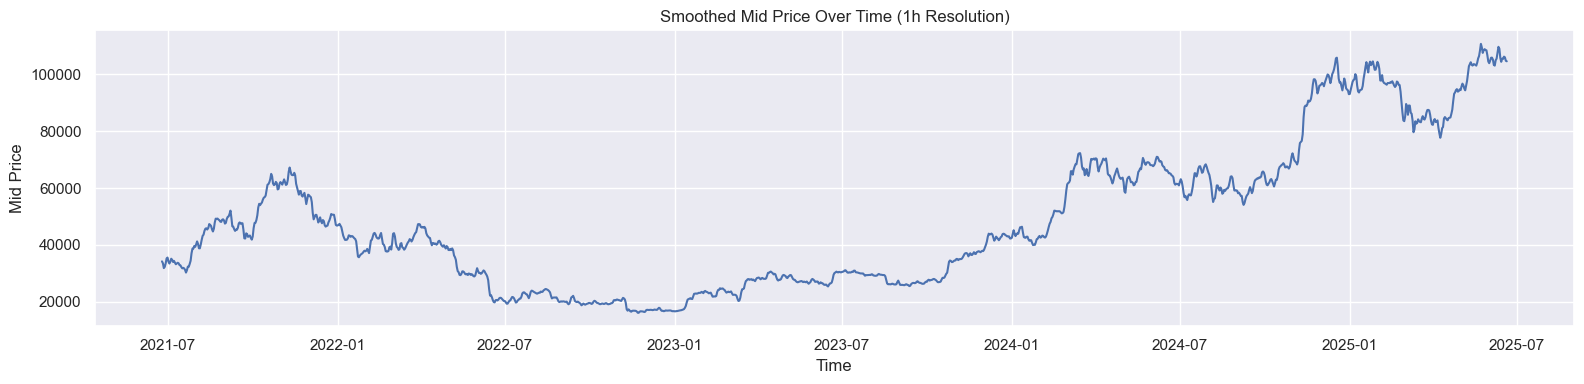

In [16]:
plt.figure()
plt.plot(df_plot["timestamp"], df_plot["mid_price_smooth"])
plt.title("Smoothed Mid Price Over Time (1h Resolution)")
plt.xlabel("Time")
plt.ylabel("Mid Price")
plt.tight_layout()
plt.show()

## Spread

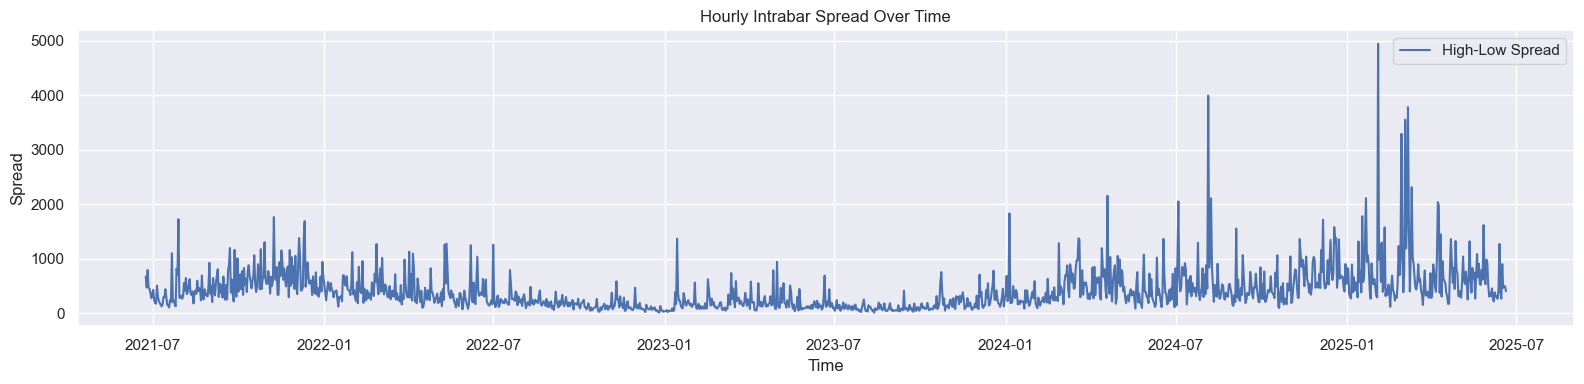

In [18]:
plt.figure()
plt.plot(df_plot["timestamp"], df_plot["spread"], label = "High-Low Spread")
plt.title("Hourly Intrabar Spread Over Time")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.tight_layout()
plt.show()

## Histogram of 1-Hour Log Returns

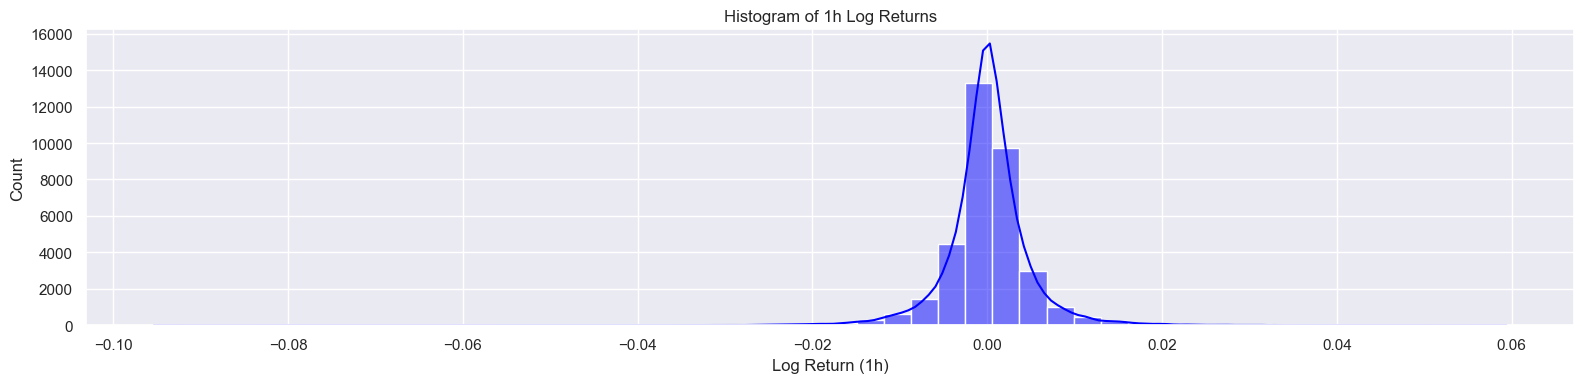

In [20]:
plt.figure()
sns.histplot(df["log_return_1h"].dropna(), bins = 50, kde = True, color = "blue")
plt.title("Histogram of 1h Log Returns")
plt.xlabel("Log Return (1h)")
plt.tight_layout()
plt.show()

## Outliers in 1-Hour Log Returns

In [22]:
q_low, q_high = df["log_return_1h"].quantile([0.01, 0.99])
df["log_return_1h_clipped"] = df["log_return_1h"].clip(q_low, q_high)
print("Number of outliers:", (df["log_return_1h"] < q_low).sum() + (df["log_return_1h"] > q_high).sum())

Number of outliers: 700


##  Histogram of 1-Hour Log Returns (clipped)

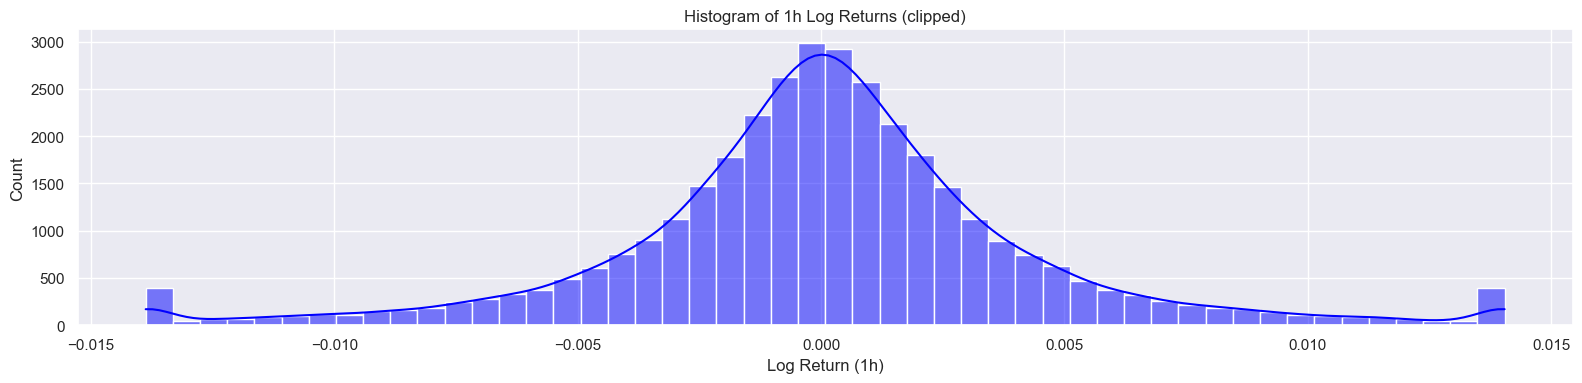

In [24]:
plt.figure()
sns.histplot(df["log_return_1h_clipped"], bins=50, kde=True, color="blue")
plt.title("Histogram of 1h Log Returns (clipped)")
plt.xlabel("Log Return (1h)")
plt.tight_layout()
plt.show()

## Heatmap of Feature Correlations

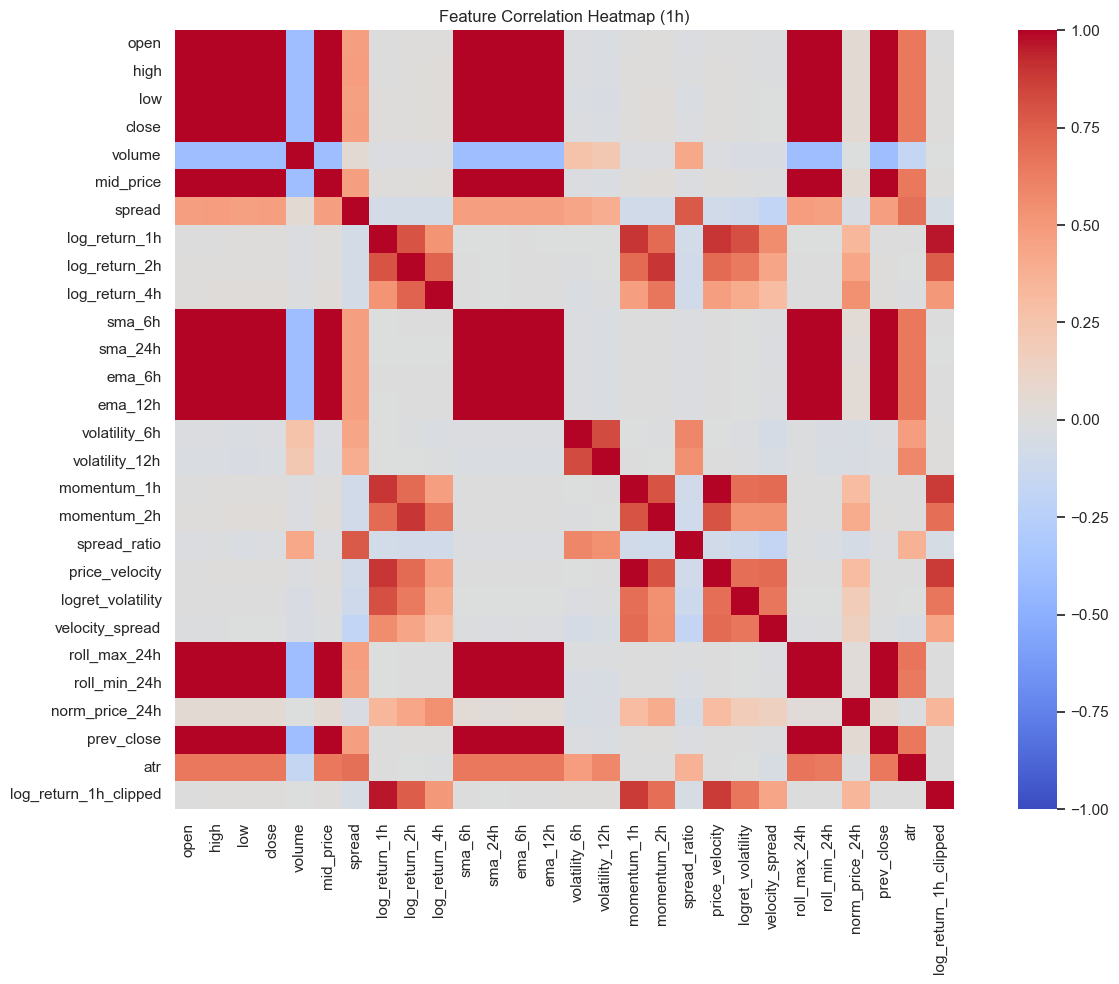

In [26]:
plt.figure(figsize=(14, 10))
numeric_cols = df.select_dtypes(include="number")
corr = numeric_cols.corr()
sns.heatmap(corr, cmap="coolwarm", vmin = -1, vmax = 1, center=0, square=True)
plt.title("Feature Correlation Heatmap (1h)")
plt.tight_layout()
plt.show()

##  ACF and PACF of 1-Hour Log Returns

<Figure size 1200x400 with 0 Axes>

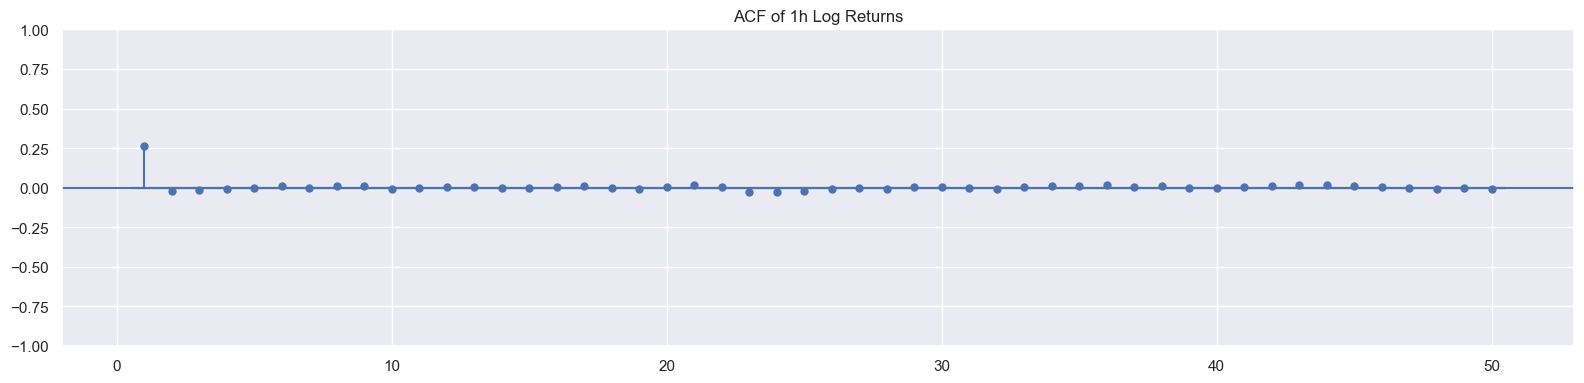

<Figure size 1200x400 with 0 Axes>

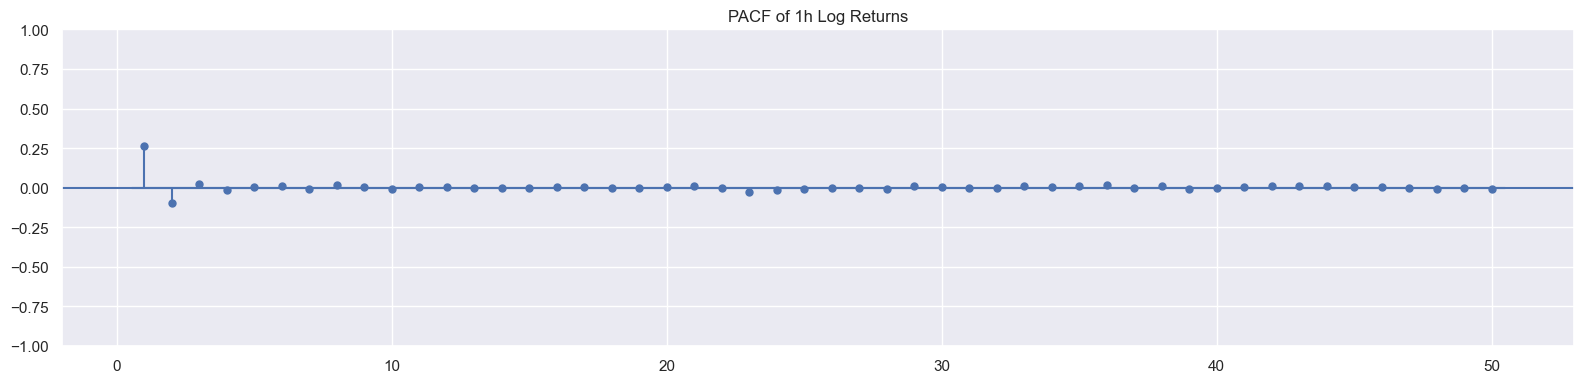

In [28]:
series = df["log_return_1h"].dropna()

plt.figure(figsize=(12, 4))
plot_acf(series, lags = 50, title = "ACF of 1h Log Returns", zero = False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(series, lags = 50, title = "PACF of 1h Log Returns", zero = False, method = "ywm")
plt.tight_layout()
plt.show()

## PCA: Determine number of components to explain 90% variance

Saved 6 PCA components to data/pca_transformed.csv


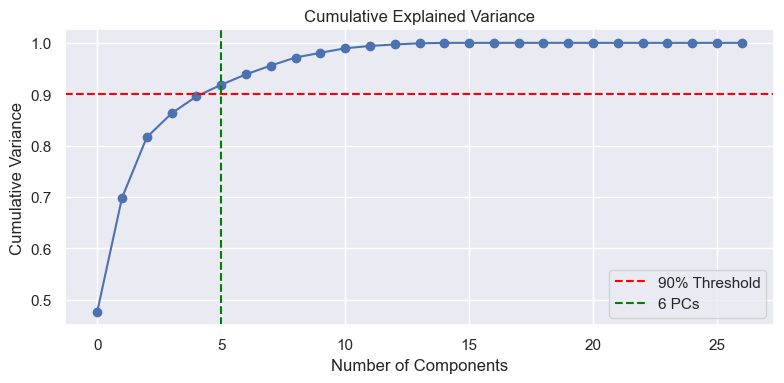

In [30]:
df = pd.read_csv("data/engineered_features.csv", parse_dates = ["timestamp"])
timestamps = df["timestamp"]
X_raw = df.drop(columns = ["timestamp"]).replace([np.inf, -np.inf], np.nan).dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# PCA: Full fit to get cumulative variance
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)
explained_var = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(explained_var >= 0.90) + 1

# PCA: Final transform with optimal number of components
pca = PCA(n_components = n_components_90)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns = [f"PC{i+1}" for i in range(n_components_90)])
X_pca_df.insert(0, "timestamp", timestamps.iloc[-len(X_pca):].values)

# Save
X_pca_df.to_csv("data/pca_transformed.csv", index = False)
print(f"Saved {n_components_90} PCA components to data/pca_transformed.csv")

# Plot: Explained Variance
plt.figure(figsize = (8, 4))
plt.plot(explained_var, marker = 'o')
plt.axhline(0.90, color = 'red', linestyle = '--', label = "90% Threshold")
plt.axvline(n_components_90 - 1, color = 'green', linestyle = '--', label = f"{n_components_90} PCs")
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance")
plt.legend()
plt.tight_layout()
plt.show()

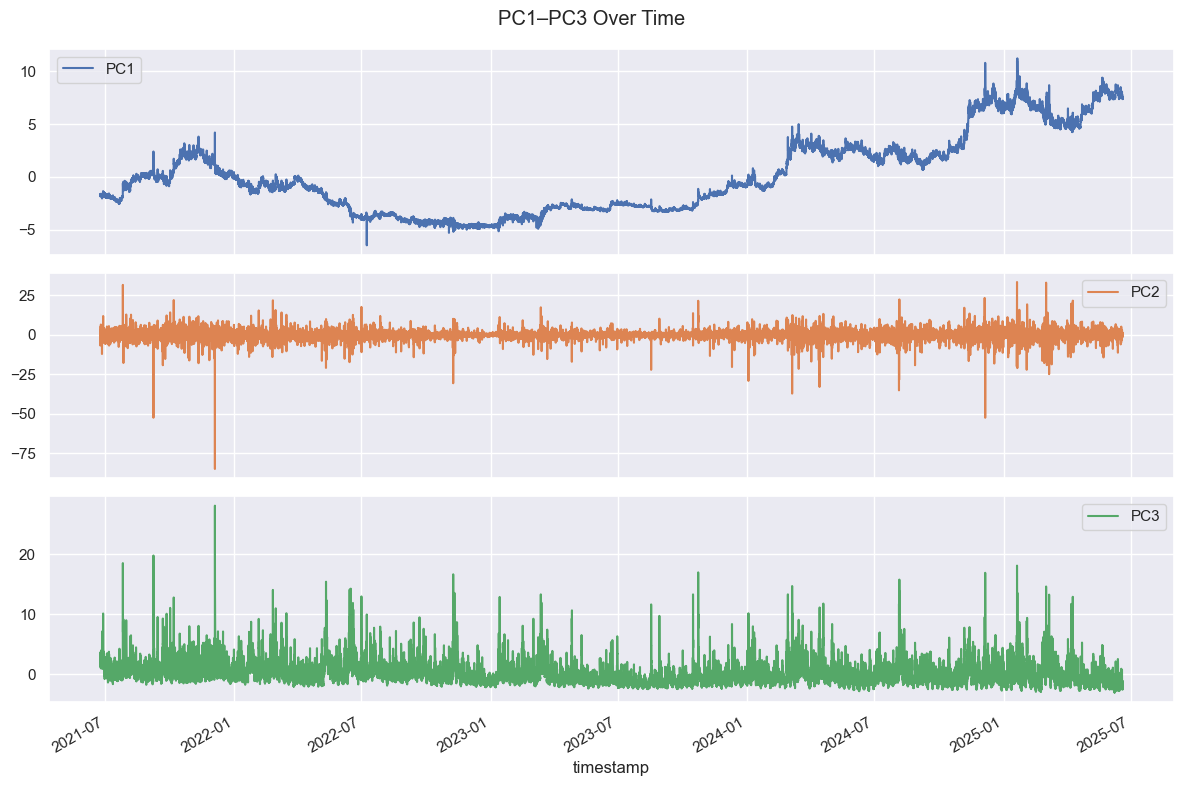

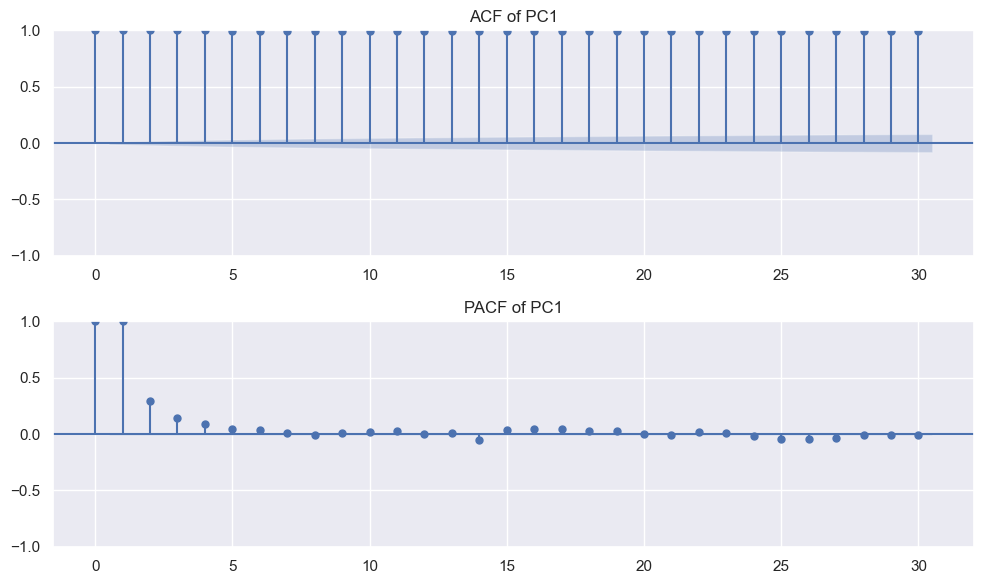

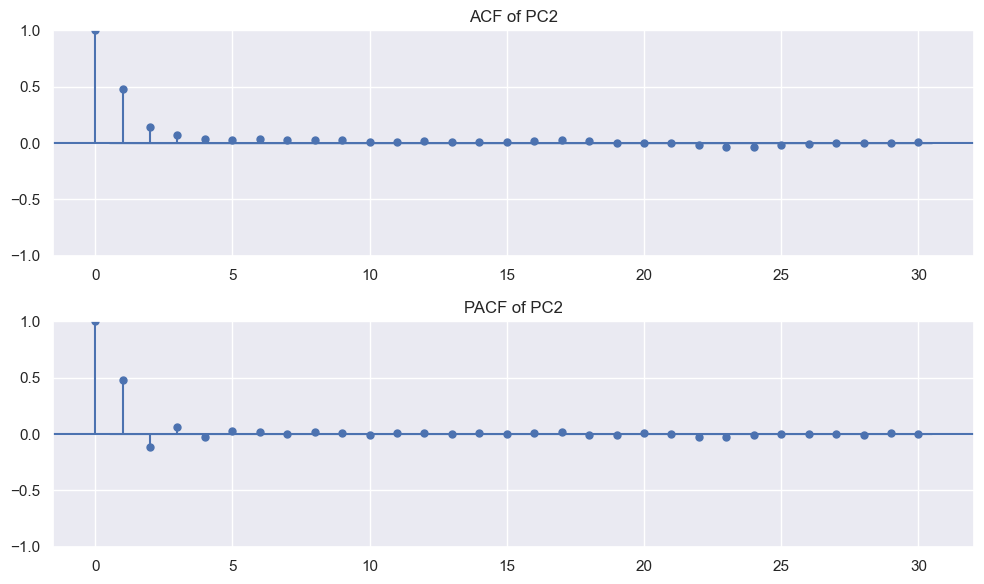

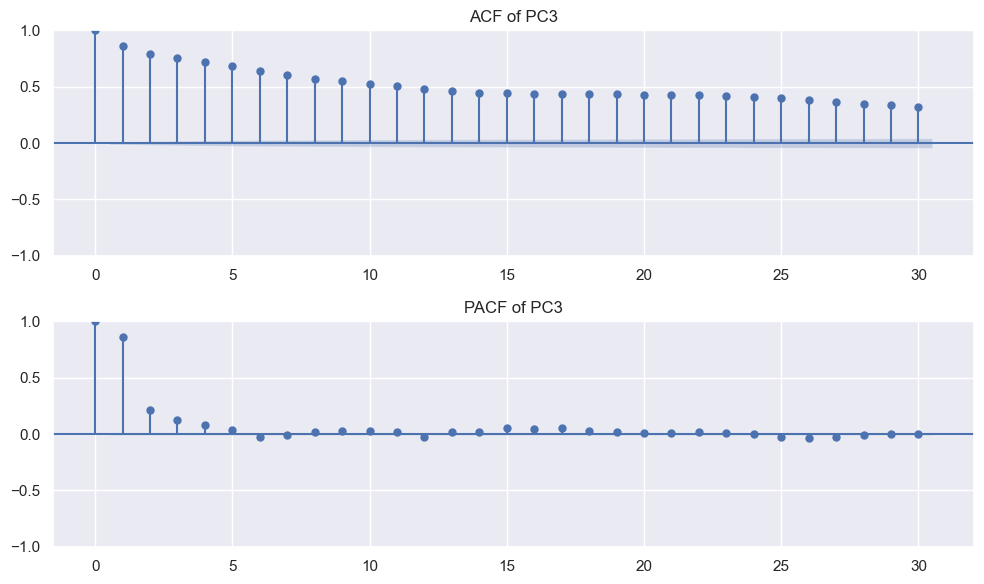

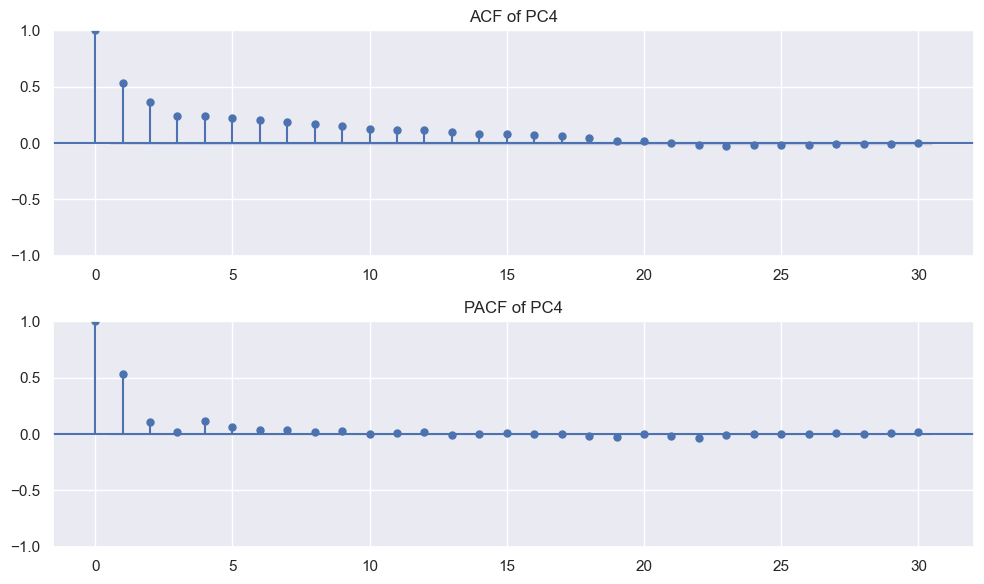

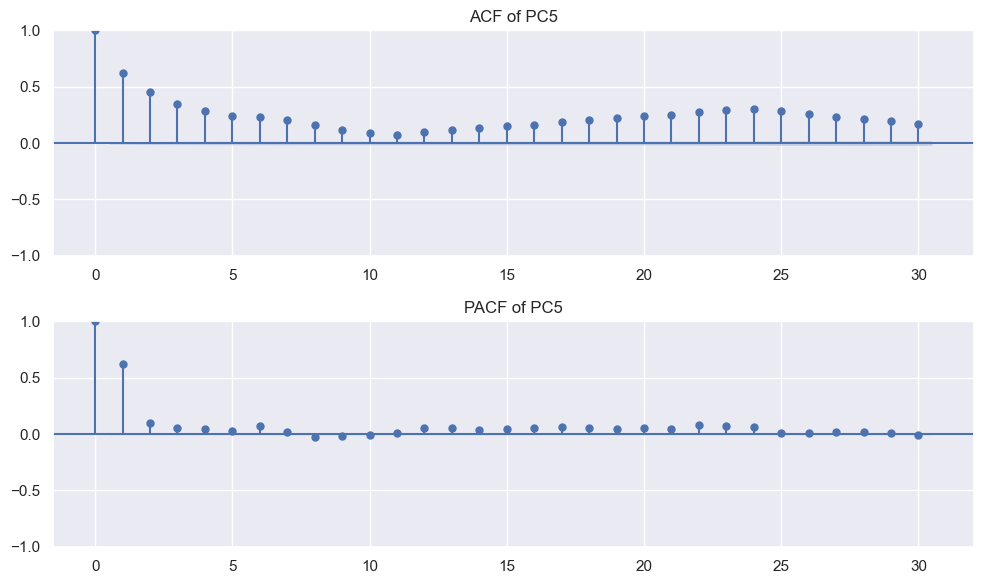

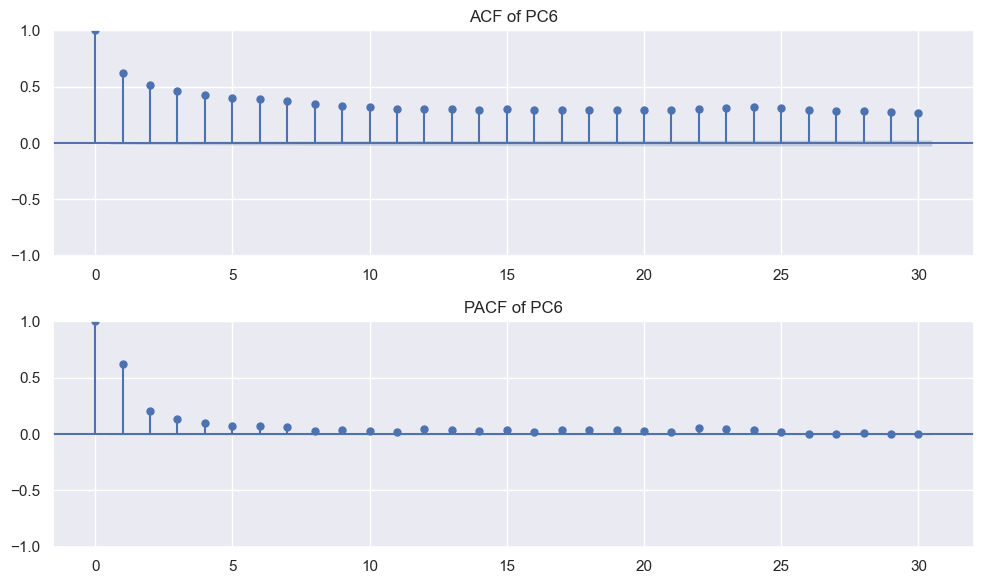

In [31]:
warnings.filterwarnings("ignore")

df_pca = pd.read_csv("data/pca_transformed.csv", parse_dates=["timestamp"])
X_pca_df = df_pca.drop(columns=["timestamp"])

# Plot PCs
df_pca.set_index("timestamp")[["PC1", "PC2", "PC3"]].plot(subplots=True, figsize=(12, 8), title="PC1–PC3 Over Time")
plt.tight_layout()
plt.show()

# ACF/PACF of PCs
for i in range(1, X_pca_df.shape[1] + 1):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    plot_acf(X_pca_df[f"PC{i}"], ax=axs[0], lags=30)
    plot_pacf(X_pca_df[f"PC{i}"], ax=axs[1], lags=30)
    axs[0].set_title(f"ACF of PC{i}")
    axs[1].set_title(f"PACF of PC{i}")
    plt.tight_layout()
    plt.show()

In [32]:
for col in X_pca_df.columns:
    best_aic = float("inf")
    best_model = None
    best_lag = None
    for lag in range(1, 6):
        model = AutoReg(X_pca_df[col], lags=lag, old_names=False).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_model = model
            best_lag = lag
    print(f"\n🔹 Best AR model for {col}: AR({best_lag}) with AIC = {best_aic:.2f}")
    print(best_model.summary())


🔹 Best AR model for PC1: AR(5) with AIC = -51627.31
                            AutoReg Model Results                             
Dep. Variable:                    PC1   No. Observations:                34970
Model:                     AutoReg(5)   Log Likelihood               25820.653
Method:               Conditional MLE   S.D. of innovations              0.116
Date:                Fri, 20 Jun 2025   AIC                         -51627.306
Time:                        10:56:19   BIC                         -51568.071
Sample:                             5   HQIC                        -51608.437
                                34970                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.793      0.428      -0.001       0.002
PC1.L1         0.5904      0.005    110.677      0.000       0.580       0.601

In [33]:
for lag in range(7):
    ar_model = AutoReg(X_pca_df["PC1"], lags=lag, old_names=False).fit()
    print(ar_model.summary())
    print(f"AIC of AR({lag}) for PC1: {ar_model.aic:.2f}")

                            AutoReg Model Results                             
Dep. Variable:                    PC1   No. Observations:                34970
Model:                     AutoReg(0)   Log Likelihood              -94289.933
Method:               Conditional MLE   S.D. of innovations              3.587
Date:                Fri, 20 Jun 2025   AIC                         188583.866
Time:                        10:56:20   BIC                         188600.791
Sample:                             0   HQIC                        188589.258
                                34970                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const               0      0.019          0      1.000      -0.038       0.038
AIC of AR(0) for PC1: 188583.87
                            AutoReg Model Results                             
Dep. Variable:      

We should use AR(1) instead of AR(5) for PC1.
In fact AR(5) has only a slightly lower AIC, but at the cost of 4 more terms (more complicated).

Sometimes we should use AR(0) instead of AR(p) for PC. That means PC is a white noise.

Intuition: Why PC can be white noise ?
- PCA ranks components by variance explained, not by predictability or temporal structure.

- So PC often captures high-variance noise, especially in noisy high-frequency financial data.

- PCs with lower variance can still encode mean-reverting, trend-following, or autocorrelated signals — just with smaller amplitude.

Based on ACF and PACF, we use the following models for principal components

- PC1 : AR(1)
- PC2 : AR(1)
- PC3 : AR(1)
- PC4 : AR(2)
- PC5 : AR(1)
- PC6 : AR(1)


In [37]:
# === Load PCA ===
df_pca = pd.read_csv("data/pca_transformed.csv", parse_dates=["timestamp"])

# === Define AR(p) orders (manually selected) ===
ar_orders = {
    "PC1": 1,
    "PC2": 1,
    "PC3": 1,
    "PC4": 2,
    "PC5": 1,
    "PC6": 1,
}

# === Forecast each PC using AR(p) ===
for pc, lag in ar_orders.items():
    series = df_pca[pc]

    if lag == 0 or lag >= len(series):
        forecast = np.full_like(series, fill_value=series.mean(), dtype=np.float64)
    else:
        model = AutoReg(series, lags=lag, old_names=False).fit()
        forecast = model.predict(start=lag, end=len(series)-1)
        forecast = np.concatenate([[np.nan]*lag, forecast])

    df_pca[f"{pc}_forecast"] = forecast

# === Save forecasted PCA ===
output_path = "data/pca_with_ar_forecasts.csv"
df_pca.to_csv(output_path, index=False)
print(f"Saved forecast-augmented PCA to: {output_path}")

Saved forecast-augmented PCA to: data/pca_with_ar_forecasts.csv


# 3. Strategies

## Backtest and evaluate — with all metrics

In [79]:
def compute_drawdown(pnl_series):
    peak = pnl_series.expanding().max()
    drawdown = peak - pnl_series
    max_dd = drawdown.max()

    dd_duration = (
        (drawdown > 0)
        .astype(int)
        .groupby((drawdown == 0).astype(int).cumsum())
        .sum()
        .max()
    )
    return max_dd, int(dd_duration or 0)


def backtest_and_evaluate(trades_list, full_df, output_prefix = "strategy", initial_capital = 1_000_000, bars_per_year = 24 * 252,):
    # ------------- 1. Basic trade table  --------------------------------
    results = pd.DataFrame(trades_list)
    if results.empty:
        print("No trades executed.")
        return results

    results.sort_values("timestamp", inplace=True)
    results.reset_index(drop=True, inplace=True)
    results["cum_pnl"] = results["pnl"].cumsum()
    results["strategy_return"] = results["pnl"] / results["entry_price"]

    # ------------- 2. Build equity curve  -------------------------------
    # Expand results to a time-series indexed exactly like full_df
    df_ts = pd.Series(data=0.0, index=full_df["timestamp"])
    for _, row in results.iterrows():
        exit_idx = full_df.index[full_df["timestamp"] == row["timestamp"]]
        if not exit_idx.empty:
            df_ts.iloc[exit_idx[0]] += row["pnl"]  # realised PnL at exit bar

    equity_curve = df_ts.cumsum() + initial_capital
    equity_curve = equity_curve.ffill()  # hold last equity value

    # ------------- 3. Log-return series (strategy & BTC) ----------------
    strat_log_ret = np.log(equity_curve).diff().fillna(0)

    btc_log_ret = (
        np.log(full_df.set_index("timestamp")["mid_price"])
        .diff()
        .reindex(equity_curve.index)  # ensure same index
        .fillna(0)
    )

    # ------------- 4. Risk metrics --------------------------------------
    sharpe = strat_log_ret.mean() / strat_log_ret.std(ddof=0) if strat_log_ret.std() else np.nan
    sortino = strat_log_ret.mean() / strat_log_ret[strat_log_ret < 0].std(ddof=0) if strat_log_ret[strat_log_ret < 0].std(ddof=0) else np.nan
    sharpe_ann, sortino_ann = np.sqrt(bars_per_year) * np.array([sharpe, sortino])

    profits = results.loc[results["pnl"] > 0, "pnl"].sum()
    losses = results.loc[results["pnl"] < 0, "pnl"].sum()
    profit_factor = profits / -losses if losses != 0 else np.nan

    correct = (
        ((results["signal"] == 1) & (results["pnl"] > 0))
        | ((results["signal"] == -1) & (results["pnl"] > 0))
    )
    hit_ratio = correct.mean()

    exposure = results["hold_time"].sum() / len(full_df)

    max_dd, dd_duration = compute_drawdown(equity_curve - initial_capital)

    # ------------- 5. alpha / beta -----------------------------
    aligned = pd.DataFrame({"strategy": strat_log_ret, "btc": btc_log_ret}).dropna()
    if len(aligned) > 0 and aligned["btc"].std(ddof=0) > 0:
        lr = LinearRegression(fit_intercept=True).fit(aligned[["btc"]], aligned["strategy"])
        alpha_hourly, beta = lr.intercept_, lr.coef_[0]
        alpha_ann = alpha_hourly * bars_per_year
    else:
        alpha_hourly = beta = alpha_ann = np.nan

    # ------------- 6. Plot cumulative PnL -------------------------------
    os.makedirs("plots", exist_ok=True)
    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve.index, equity_curve - initial_capital, label="Strategy Cumulative PnL", lw=1.4)
    btc_pnl = full_df["mid_price"] - full_df["mid_price"].iloc[0]
    plt.plot(full_df["timestamp"], btc_pnl, label="BTC Buy & Hold", linestyle="--", lw=1.0)
    plt.title(f"{output_prefix}: Strategy vs BTC Buy-and-Hold")
    plt.xlabel("Time (hourly)")
    plt.ylabel("PnL (USD)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"plots/{output_prefix}_cum_pnl.png", dpi=150)

    # ------------- 7. Console summary -----------------------------------
    print(f"\n{output_prefix}: Backtest Evaluation")
    print("-" * 60)
    print(f"Total PnL                    : {results['pnl'].sum():,.2f}")
    print(f"Mean PnL per trade           : {results['pnl'].mean():,.4f}")
    print(f"Mean return per trade (%)    : {results['strategy_return'].mean() * 100:,.2f}%")
    print(f"Hit ratio                    : {hit_ratio:,.2%}")
    print(f"Number of trades             : {len(results)}")
    print(f"Average hold time (hrs)      : {results['hold_time'].mean():,.2f}")
    print(f"Profit factor                : {profit_factor:,.2f}")
    print(f"Exposure                     : {exposure:,.2%}")
    print(f"Max draw-down                : {max_dd:,.2f}")
    print(f"Longest draw-down (hrs)      : {dd_duration}")
    print(f"Sharpe ratio (annualised)    : {sharpe_ann:,.2f}")
    print(f"Sortino ratio (annualised)   : {sortino_ann:,.2f}")
    print(f"Alpha (annualised, log-ret)  : {alpha_ann * 100:,.2f}%")
    print(f"Beta to BTC                  : {beta:,.4f}")
    print("-" * 60)

    # ------------- 8. Return enriched trade table -----------------------
    return results.assign(equity=equity_curve.reindex(results["timestamp"]).values)


# Strategy 1: Mean-reversion and uncertainty zone

## Source  

Extension using **PCA residuals** and **ATR-based exits** of Robert & Rosenbaum (2010) – *"A new approach for the dynamics of ultra-high-frequency data: The model with uncertainty zones"*.

---

## Summary of idea

This strategy builds on the Uncertainty Zone directional signal by:

- Adding **residual-based entry filtering** using the first principal component (PC1) and its AR forecast
- Adding **take-profit / stop-loss exit rules** based on ATR
- The goal is to improve entry precision and enforce risk control

**Motivation**:
- If PC1 is significantly below its forecast but the price is moving up -> likely to mean-revert -> **buy**
- If PC1 is above its forecast but the price is moving down -> **sell**
- Use ATR to determine dynamic thresholds for exit

---

## Strategy logic

1. **Signal Construction**:
    - Take Uncertainty Zone signal (`+1`, `-1`, or `0`)
    - Compute residual:  
      $$ \text{residual}_t = \text{PC1}_t - \text{PC1}^{\text{forecast}}_t $$
    - Entry signal =  
      - `+1` if signal is `+1` and residual is `< -threshold`  
      - `-1` if signal is `-1` and residual is `> threshold`  
      - `0` otherwise

2. **Trade Execution**:
    - Entry at mid-price at time $t$ when filtered signal is nonzero
    - Exit when one of the following is hit:
        - **Take Profit**:  
          $$ \text{PnL} \geq 2.0 \times \text{ATR}_t $$
        - **Stop Loss**:  
          $$ \text{PnL} \leq -0.01 \times \text{ATR}_t $$
        - **Max Hold**: 12 hours
    - Net PnL includes 0.1% transaction cost (round trip)

---

## Pros

1. **Feature-informed entry** – Uses PCA and residuals for smarter filtering  
2. **Dynamic exit rules** – ATR adapts to changing volatility  
3. **Risk managed** – Every trade has a bounded loss potential  

---

## Cons

1. **Residual threshold fixed** – `0.01` may not generalize well  
2. **Forecast model is univariate AR(2)** – No multi-PC interaction  
3. **No position sizing or compounding** – Flat-size trades only  
4. **Low market exposure** – Strategy sits out most of the time

---



strategy1_residual_tp_sl: Backtest Evaluation
------------------------------------------------------------
Total PnL                    : 25,844.77
Mean PnL per trade           : 113.8536
Mean return per trade (%)    : 0.18%
Hit ratio                    : 33.92%
Number of trades             : 227
Average hold time (hrs)      : 4.19
Profit factor                : 1.46
Exposure                     : 2.72%
Max draw-down                : 7,199.32
Longest draw-down (hrs)      : 23697
Sharpe ratio (annualised)    : 0.80
Sortino ratio (annualised)   : 0.12
Alpha (annualised, log-ret)  : 0.45%
Beta to BTC                  : -0.0006
------------------------------------------------------------


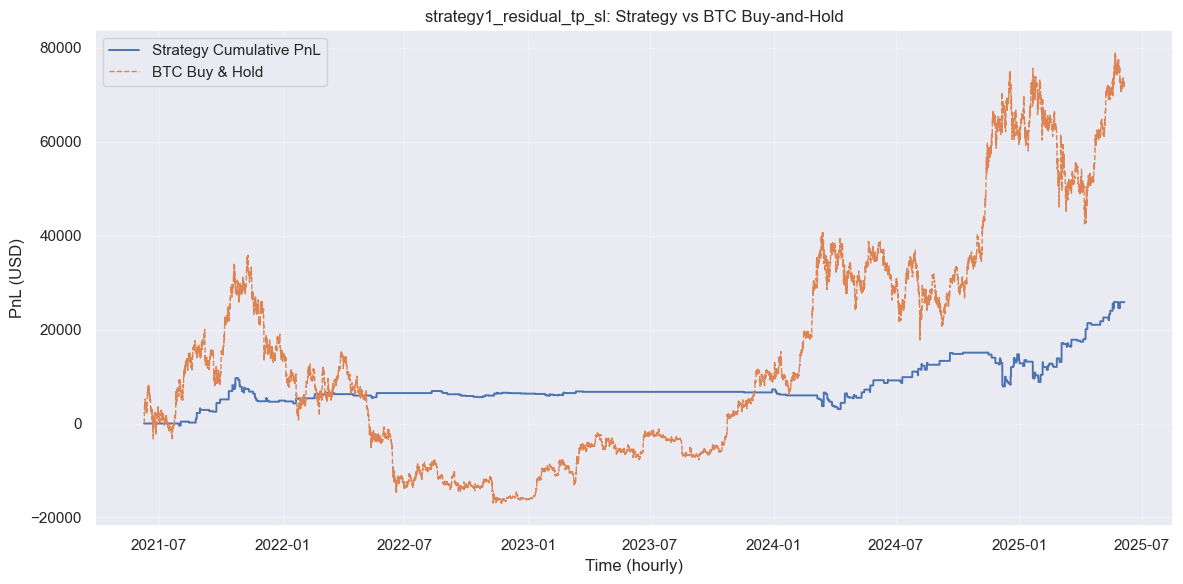

In [82]:
# === Load preprocessed DataFrame ===
df = pd.read_csv("data/merged_with_atr_confidence.csv", parse_dates=["timestamp"])

# === Strategy Parameters ===
transaction_cost_pct = 0.001
resid_thresh = 0.1        # residual threshold for mean reversion
tp_mult = 2.0              # take profit multiple of ATR
sl_mult = 0.01              # stop loss multiple of ATR
max_hold = 12              # max hold in bars (hours)
bars_per_year = 24 * 252   # annualization factor

# === Inputs ===
mid = df["mid_price"].values
atr = df["atr"].values
signal = df["filtered_signal"].values  # from uncertainty zone
pc1 = df["PC1"].values
pc1_forecast = df["PC1_forecast"].values
residual = pc1 - pc1_forecast
timestamps = df["timestamp"].values

# === Entry Signal: residual reversal with uncertainty zone agreement ===
entry_signal = np.where(
    ((signal == 1) & (residual < -resid_thresh)) |
    ((signal == -1) & (residual > resid_thresh)),
    signal,
    0
)

# === Trade Execution ===
position = 0
entry_price = None
entry_time = None
trades = []

for t in range(len(df)):
    if position == 0 and entry_signal[t] != 0:
        position = entry_signal[t]
        entry_price = mid[t]
        entry_time = t

    elif position != 0:
        gain = (mid[t] - entry_price) * position
        TP = atr[t] * tp_mult
        SL = atr[t] * sl_mult
        hold_time = t - entry_time

        if gain >= TP or gain <= -SL or hold_time >= max_hold:
            exit_price = mid[t]
            raw_pnl = (exit_price - entry_price) * position
            cost = (entry_price + exit_price) * transaction_cost_pct
            net_pnl = raw_pnl - cost

            trades.append({
                "timestamp": timestamps[t],
                "signal": position,
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl": net_pnl,
                "hold_time": hold_time
            })

            # Reset state
            position = 0
            entry_price = None
            entry_time = None

# === Run Evaluation ===
results = backtest_and_evaluate(trades, df, output_prefix = "strategy1_residual_tp_sl", bars_per_year = bars_per_year)

## Interpretation

- This strategy trades infrequently (low exposure) but has a high Sharpe ratio due to favorable risk-adjusted returns.
- The high alpha reflects consistent edge over BTC during trade intervals.
- Negative beta implies it often profits during BTC declines — a possible hedge.
- Profit factor > 1.4 suggests strong reward-to-risk.

Transactions

In [86]:
results.query("signal != 0")[["entry_price", "exit_price", "pnl"]]

,entry_price,exit_price,pnl
0,39110.925,39465.725,-433.376650
1,40596.300,39681.060,834.962640
2,46417.375,46305.070,-205.027445
3,48893.640,47998.940,797.807420
4,48276.015,46924.815,1255.999170
...,...,...,...
222,108326.470,108783.215,-673.854685
223,109109.370,108759.880,-567.359250
224,109257.895,108791.920,247.925185
225,107527.475,107629.155,-316.836630


exit_price - entry_price

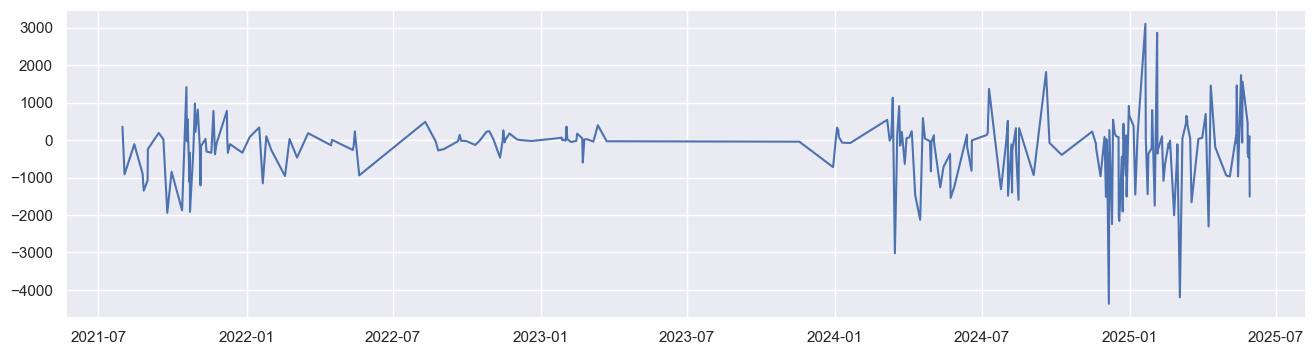

In [89]:
plt.plot(results["timestamp"], results["exit_price"] - results["entry_price"])
plt.show()

# Strategy 2: ML Voting 

## Source  
This strategy implements:

- **Ensemble model voting** using Ridge, Random Forest, and LightGBM
- **Realistic execution assumptions** (bid/ask spread, transaction cost, slippage)
- **Market re-entry logic** with timeout thresholds

---

## Summary of idea  

This strategy applies machine learning models to forecast short-term (16-hour) returns using **PCA-compressed features**.  
Trading signals are generated only when **at least two models agree** on the direction.  
Execution is constrained by realistic assumptions: we buy at the ask and sell at the bid, incurring a **transaction cost** per round-trip.  
If no strong signal appears, the system remains flat for up to 32 hours before re-entering by default.

Additionally, we model **trading volume**:  
- Trade 1 BTC when weak consensus (2 out of 3 models)  
- Trade 2 BTC when all models agree on direction  

---

## Strategy logic

1. **Feature preparation**:
    - Use PCA to extract top 6 components from engineered market features.
    - Construct target as `log_return_16h` (future return after 16 hours).
    - Add `order_flow_imbalance = spread.diff()` as a simple proxy.

2. **Training and inference**:
    - At each decision point (every 5 bars), fit Ridge, RF, and LGBM to past 100 samples.
    - Predict the next return using all three models.

3. **Voting logic**:
    - Count the signs of the three predictions:
        - If 2 agree: trade 1 BTC
        - If 3 agree: trade 2 BTC
    - Only act if the OFI has the same direction as the vote.

4. **Execution**:
    - Buy at `mid + spread/2`; sell at `mid - spread/2`
    - Subtract round-trip transaction cost from PnL.

5. **Fallback logic**:
    - If no signal appears for 32 hours, re-enter the market by default.

6. **Mark-to-market** if still in a position at the end of the backtest.

---

## Pros

1. **Execution-aware** – Accounts for spread, slippage, and transaction costs  
2. **Volume-sensitive logic** – Trades more confidently when models strongly agree  
3. **Realistic behavior** – Avoids overtrading, implements fallback re-entry

---

## Cons

1. **Still simplified** – OFI is crude (spread.diff), and real market impact is more complex  
2. **Model retraining per bar** – Inefficient and unrealistic for live trading  
3. **PnL sensitive to timing** – Signal quality degrades if prediction horizon or frequency is off  


strategy2_ml_voting_realistic: Backtest Evaluation
------------------------------------------------------------
Total PnL                    : 159,490.01
Mean PnL per trade           : 373.5129
Mean return per trade (%)    : 0.87%
Hit ratio                    : 44.26%
Number of trades             : 427
Average hold time (hrs)      : 52.59
Profit factor                : 1.38
Exposure                     : 64.24%
Max draw-down                : 36,894.50
Longest draw-down (hrs)      : 16670
Sharpe ratio (annualised)    : 0.81
Sortino ratio (annualised)   : 0.17
Alpha (annualised, log-ret)  : 2.56%
Beta to BTC                  : 0.0000
------------------------------------------------------------


,timestamp,entry_price,exit_price,pnl,signal,hold_time,volume,cum_pnl,strategy_return,equity
0,2021-06-28 14:00:00,34469.14,34216.58,-642.49144,-1,15.0,2,-642.49144,-0.018640,9.993575e+05
1,2021-06-30 21:00:00,35950.00,34580.00,-2881.06000,-1,20.0,2,-3523.55144,-0.080141,9.964764e+05
2,2021-07-05 01:00:00,33917.93,34445.33,918.07348,-1,85.0,2,-2605.47796,0.027067,9.973945e+05
3,2021-07-07 08:00:00,34448.00,34670.06,305.88388,-1,20.0,2,-2299.59408,0.008880,9.977004e+05
4,2021-07-09 10:00:00,32800.00,32810.00,-111.22000,-1,20.0,2,-2410.81408,-0.003391,9.975892e+05
...,...,...,...,...,...,...,...,...,...,...
422,2025-06-05 09:00:00,104487.82,104675.35,-43.26634,-1,70.0,2,152061.29183,-0.000414,1.152061e+06
423,2025-06-12 01:00:00,101907.00,108258.49,6141.32451,-1,145.0,1,158202.61634,0.060264,1.158203e+06
424,2025-06-13 22:00:00,105290.14,105542.00,41.02786,-1,10.0,1,158243.64420,0.000390,1.158244e+06
425,2025-06-17 01:00:00,105197.19,106930.23,1520.91258,-1,40.0,1,159764.55678,0.014458,1.159765e+06


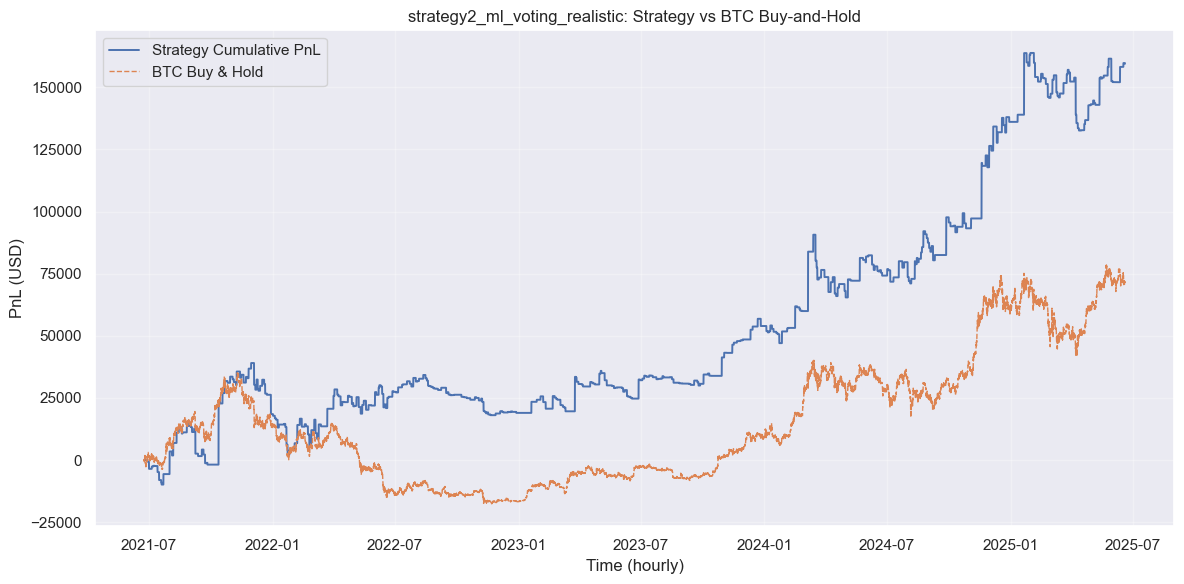

In [92]:
warnings.filterwarnings("ignore")
# === Parameters ===
train_window = 100
lookahead = 16
max_unhold = 32
step = 5
transaction_cost_pct = 0.001
transaction_success_rate = 0.8
min_abs_return = 0.0015
volume_strong = 2  # trade volume if all 3 models agree
features = [f"PC{i}" for i in range(1, 6)]
target = "log_return_16h"

# === Load & merge data ===
df_feat = pd.read_csv("data/engineered_features.csv", parse_dates = ["timestamp"])
df_pca = pd.read_csv("data/pca_with_ar_forecasts.csv", parse_dates = ["timestamp"])
df = pd.merge(df_feat, df_pca, on = "timestamp", how = "inner").sort_values("timestamp").reset_index(drop = True)

# === Preprocess ===
df[target] = np.log(df["mid_price"].shift(-lookahead) / df["mid_price"])
df["order_flow_imbalance"] = df["spread"].diff()
df = df.dropna(subset = features + [target, "mid_price", "timestamp", "order_flow_imbalance", "spread"]).reset_index(drop = True)

# === Strategy Logic ===
trades = []
in_market = True
position = 1  # Start by holding 1 BTC
entry_price = df["mid_price"].iloc[train_window]
entry_time = df["timestamp"].iloc[train_window]

for t in range(train_window, len(df) - lookahead, step):
    X_train = df[features].iloc[t - train_window:t].values
    y_train = df[target].iloc[t - train_window:t].values
    X_test = df[features].iloc[t].values.reshape(1, -1)
    mid = df["mid_price"].iloc[t]
    ts = df["timestamp"].iloc[t]
    ofi = df["order_flow_imbalance"].iloc[t]
    spread = df["spread"].iloc[t]

    models = [
        Ridge(alpha = 1.0),
        RandomForestRegressor(n_estimators = 10, max_depth = 4),
        LGBMRegressor(n_estimators = 10, max_depth = 4, verbosity = -1)
    ]

    votes = []
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]
        if abs(pred) < min_abs_return:
            votes.append(0)
        else:
            votes.append(np.sign(pred))

    vote_sum = sum(votes)
    direction = np.sign(vote_sum)
    vote_strength = abs(vote_sum)

    if in_market:
        if direction == -1 and np.sign(ofi) == -1 and vote_strength >= 2:
            if random.random() <= transaction_success_rate:
                volume = 1 if vote_strength == 2 else volume_strong
                execution_price = mid - spread / 2
                cost = (entry_price + execution_price) * transaction_cost_pct * volume
                pnl = (execution_price - entry_price) * volume - cost
                trades.append({
                    "timestamp": ts,
                    "entry_price": entry_price,
                    "exit_price": execution_price,
                    "pnl": pnl,
                    "signal": -1,
                    "hold_time": (ts - entry_time).total_seconds() / 3600,
                    "volume": volume
                })
                in_market = False
                exit_time = ts
            else:
                # Trade failed to execute
                pass
    else:
        unheld_time = (ts - exit_time).total_seconds() / 3600
        if (direction == 1 and np.sign(ofi) == 1 and vote_strength >= 2) or (unheld_time >= max_unhold):
            if random.random() <= transaction_success_rate:
                volume = 1 if vote_strength == 2 else volume_strong
                execution_price = mid + spread / 2
                entry_price = execution_price
                entry_time = ts
                in_market = True
            else:
                # Re-entry trade failed
                pass

# === Mark-to-market if still holding
if in_market:
    final_price = df["mid_price"].iloc[-1] - df["spread"].iloc[-1] / 2
    final_ts = df["timestamp"].iloc[-1]
    cost = (entry_price + final_price) * transaction_cost_pct
    pnl = (final_price - entry_price) - cost
    trades.append({
        "timestamp": final_ts,
        "entry_price": entry_price,
        "exit_price": final_price,
        "pnl": pnl,
        "signal": -1,
        "hold_time": (final_ts - entry_time).total_seconds() / 3600,
        "volume": 1
    })

# === Run backtest
results = pd.DataFrame(trades)
backtest_and_evaluate(results, df, output_prefix = "strategy2_ml_voting_realistic")

---

## Alpha interpretation

We report **alpha via time-series regression** between per-hour strategy returns and BTC benchmark returns.

- **Alpha \not= annualized PnL**  
  Rather, it's the **intercept of the regression**: how much the strategy returns when BTC return is zero.
- This is meaningful **only when returns are dense and consistent**, not sparse.
- A high alpha with low Sharpe Ratio may suggest **irregular but large wins**, **low correlation to BTC**, or **return sparsity**.
- Use caution: **real institutional alpha** is judged against risk-adjusted performance (Sharpe, Sortino) and slippage-adjusted PnL.

## BTC Buy-and-Hold Benchmark

In [95]:
def compute_btc_metrics(df, bars_per_year=24 * 252):
    btc_price = df["mid_price"].values
    btc_ts = df["timestamp"]

    # --- Returns & PnL ---
    btc_returns = np.log(btc_price[1:] / btc_price[:-1])
    btc_cum_pnl = btc_price - btc_price[0]

    # --- Sharpe & Sortino ---
    sharpe = btc_returns.mean() / btc_returns.std() if btc_returns.std() > 0 else np.nan
    sortino = btc_returns.mean() / btc_returns[btc_returns < 0].std() if btc_returns[btc_returns < 0].std() > 0 else np.nan
    sharpe_ann = sharpe * sqrt(bars_per_year)
    sortino_ann = sortino * sqrt(bars_per_year)

    # --- Drawdown ---
    cum_pnl_series = pd.Series(btc_cum_pnl, index=btc_ts)
    peak = cum_pnl_series.expanding().max()
    drawdown = peak - cum_pnl_series
    max_dd = drawdown.max()
    dd_duration = (drawdown != 0).astype(int).groupby((drawdown == 0).astype(int).cumsum()).sum().max()

    # --- Results ---
    print("BTC Buy-and-Hold Benchmark:")
    print(f"Total PnL: {btc_cum_pnl[-1]:.2f}")
    print(f"Max Drawdown: {max_dd:.2f}")
    print(f"Drawdown Duration (hrs): {dd_duration}")
    print(f"Sharpe Ratio (annualized): {sharpe_ann:.2f}")
    print(f"Sortino Ratio (annualized): {sortino_ann:.2f}")

compute_btc_metrics(df)

BTC Buy-and-Hold Benchmark:
Total PnL: 71738.64
Max Drawdown: 52949.23
Drawdown Duration (hrs): 20377
Sharpe Ratio (annualized): 0.53
Sortino Ratio (annualized): 0.67
